<a href="https://colab.research.google.com/github/prajwalccc13/Books4U-Book-Reseller/blob/master/COMP8430_phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coin Classification using Deep Learning Techniques: RegNet and Wide ResNet


## 1 Introduction

The project aims to classify different denominations of coins from different countries.

The countries include: 'Australia', 'Japan', 'Nepal', 'New Zealand', 'United Kingdom', 'Canada', 'United States' and 'India'.

### 1.2 Dataset Collection

Dataset is collected based on countries. So, we decided on collecting dataset by dividing the countries among us. Each of us collected images of coins for 2 countries. I collected images from two countries:

1.   Australia
2.   United Kingdom

Each country have atleast 5 denominations of coins. So, each of us collected more than 500 images.

Australia have 6 denominations of coins and United Kingdom have 8 denominations of coins.

Total images of coins for each country:

- United Kingdom = 418 (8 classes)
- Australia = 306 (6 classes)

Drive Link (Dataset): https://drive.google.com/drive/folders/1g-UgIRZmp18RvbeZtlBIuyIP2Vh_wDe_?usp=share_link

## 2 Import Required Libraries

In [1]:
# Import All necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Pytorch
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision.transforms import InterpolationMode
from torchvision import datasets, transforms

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from tempfile import TemporaryDirectory

import json
from PIL import Image
import os
import time
import requests
import sys
import zipfile
from datetime import datetime
import random

In [2]:
# Setup GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

## 2 Setup Data
In this section, data is imported from google drive, dataset class is defined and data is split into training, validation and testing set.

### 2.1 Download and Extract Data

In [3]:
def download_file(url, file_path):
    """
    Downloads a file from a URL to a specified path.

    argument:
        url: The URL of the file to download.
        file_path: The local path where the file should be saved.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"File downloaded successfully to: {file_path}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")


In [4]:
def extract_file(file_path, extract_dir):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return

        if zipfile.is_zipfile(file_path):
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                zip_file.extractall(path=extract_dir)
            print(f"File extracted successfully to {extract_dir}")

        else:
            print("Error: Provided file is not a tar archive")

    except Exception as e:
        print(f"An error occurred: {e}")


In [5]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Google Drive paths -> Whole Dataset
BASE_DIR = '/content/drive/MyDrive/CoinImages/'
FILE_PATH = os.path.join(BASE_DIR, 'compressed/PreprocessedCoinImages.zip')
DATA_DIR = '/content/PreprocessedCoinImages/'
EXTRACT_DIR = '/content/'

In [7]:
# # Google Drive paths -> Robot Camera Images
# FILE_PATH_CAM = os.path.join(BASE_DIR, 'compressed/PreprocessedCamImages.zip')
# DATA_DIR_CAM = '/content/PreprocessedCamImages/'

In [8]:
# Check if the data folder exists -> Whole Dataset
if not os.path.exists(DATA_DIR):
  extract_file(FILE_PATH, EXTRACT_DIR)

File extracted successfully to /content/


In [9]:
# # Check if the data folder exists -> Robot Camera Images
# if not os.path.exists(DATA_DIR_CAM):
#   extract_file(FILE_PATH_CAM, EXTRACT_DIR)

In [10]:
# CSV paths -> Whole Dataset
CSV_DIR = os.path.join(BASE_DIR, 'csv')
# CSV_PATH = os.path.join(CSV_DIR, 'processed_data.csv')
CSV_PATH = '/content/PreprocessedCoinImages/processed_data.csv'


# Load dataset
df_coins_all = pd.read_csv(CSV_PATH) # whole dataset

In [11]:
# # CSV paths -> Robot Camera Images
# CSV_PATH_CAM = '/content/PreprocessedCamImages/processed_cam_data.csv'

# # Load dataset
# df_coins_cam = pd.read_csv(CSV_PATH_CAM) # whole dataset

In [12]:
df_cam = df_coins_all[df_coins_all['image name'].str.contains('_cam')].reset_index(drop=True).copy()

In [13]:
df_coins = df_coins_all[~df_coins_all['image name'].str.contains('_cam')].reset_index(drop=True).copy()

In [14]:
df_cam['label'].value_counts()

,count
label,
AUD 2 Dollar,52
USD 1¢,51
10 Yen,50


In [15]:
# Dataset with all data for ['AUD 2 Dollar', '10 Yen', 'USD 1¢'] -> from phase 2 and phase 3
filtered_df = df_coins[df_coins['label'].isin(['AUD 2 Dollar', '10 Yen', 'USD 1¢'])].copy()

In [16]:
filtered_df.to_csv('filename.csv', index=False)

In [285]:
# Set which dataframe to use
df = df_coins

### 2.2 Define Dataset Class


In [18]:
class COINS(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.reset_index(drop=True)
        self.labels = pd.unique(data['label'])

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        label = row['encoded_label']
        image = Image.open(row['image_path']).convert("RGB")

        if self.transform:
          transformed_image = self.transform(image)
        else:
          transformed_image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

        return transformed_image, label

### 2.3 Split Dataset

Split dataset in appropriate sizes.
training set (60%), validation set (10%) and testing set (30%).

In [286]:
# label encoder
class_names = df['label'].unique()
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Change the image_path to local contents directory
df['image_path'] = df.apply(lambda row: os.path.join(row['URL'], row['image name'].strip()), axis=1)
df['image_path'] = df['image_path'].str.replace('drive/My Drive/CoinImages/', '', regex=False)

#### Dataset without Augmentation

In [287]:
# Split the data into training and validation sets
# 60% training, 10 % validation and 30% testing data
train_data, test_val = train_test_split(df, test_size=0.4, stratify=df['encoded_label'], random_state=5)
test_data, val_data = train_test_split(test_val, test_size=0.25, stratify=test_val['encoded_label'], random_state=5)

train_dataset = COINS(train_data)
test_dataset = COINS(test_data)
val_dataset = COINS(val_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

#### Dataset with Augmentation

In [288]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.08, 1.0), interpolation=InterpolationMode.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [289]:
train_dataset_aug = COINS(train_data, transform=transform['train'])
test_dataset_aug = COINS(test_data, transform=transform['val'])
val_dataset_aug = COINS(val_data, transform=transform['val'])

# Create data loaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=False)
val_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=False)

### Define functions

All required functions for training, evaluation and visualization are defined in this section.

In [23]:
# Training Function
def train_model(model, criterion, optimizer, train_loader, val_loader,  scheduler=None, num_epochs=25):
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': []
        }

        for epoch in range(num_epochs):
            print('-' * 20)
            print(f'Epoch {epoch} / {num_epochs - 1}')

            for split in ['train', 'val']:
                if split == 'train':
                    model.train()
                    dataloader = train_loader
                else:
                    model.eval()
                    dataloader = val_loader

                running_loss = 0.0
                correct_preds = 0

                for inputs, labels in dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(split == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if split == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item()
                    correct_preds += torch.sum(preds == labels.data)

                if scheduler is not None and split == 'train':
                    print(scheduler)
                    scheduler.step()

                # Calculate loss and accuracy
                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = correct_preds.double() / len(dataloader.dataset)


                print(f'{split} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if split == 'train':
                    metrics['train_loss'].append(float(epoch_loss))
                    metrics['train_accuracy'].append(float(epoch_acc))
                else:
                    metrics['val_loss'].append(float(epoch_loss))
                    metrics['val_accuracy'].append(float(epoch_acc))

                if split == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, metrics


In [24]:
# Evaluate the model on test set
def evaluate_model(model, dataloader, criterion, device):

    misclassified_info = {
        'images': [],
        'true_labels': [],
        'pred_labels': [],
        'true_class_names': [],
        'pred_class_names': [],
        'total_loss': 0.0,
        'total_acc': 0.0
    }

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Identify misclassified images
            misclassified = preds != labels

            # Append misclassified images and labels
            misclassified_info['images'].extend(inputs[misclassified].cpu().numpy())
            misclassified_info['true_labels'].extend(labels[misclassified].cpu().numpy())
            misclassified_info['pred_labels'].extend(preds[misclassified].cpu().numpy())

            # Convert label indices to class names
            misclassified_info['true_class_names'].extend([class_names[label] for label in labels[misclassified].cpu().numpy()])
            misclassified_info['pred_class_names'].extend([class_names[pred] for pred in preds[misclassified].cpu().numpy()])


            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

    misclassified_info['total_loss'] = running_loss / len(dataloader.dataset)
    misclassified_info['total_acc'] = running_corrects.float() / len(dataloader.dataset)

    return misclassified_info


In [25]:
def plot_metrics(metrics, title_prefix=""):
    """
    Plots training and validation accuracy and loss.
    """
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    # Plot Accuracy
    axes[0].plot(metrics['train_accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
    axes[0].plot(metrics['val_accuracy'], label='Val Accuracy', color='orange', linestyle='-', marker='x')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].set_title(f"{title_prefix} Accuracy Over Epochs")
    axes[0].legend()

    # Plot Loss
    axes[1].plot(metrics['train_loss'], label='Train Loss', color='green', linestyle='--', marker='s')
    axes[1].plot(metrics['val_loss'], label='Val Loss', color='red', linestyle='--', marker='d')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_title(f"{title_prefix} Loss Over Epochs")
    axes[1].legend()

    # Adjust layout for better spacing between plots
    plt.tight_layout()
    plt.show()

In [26]:
def plot_metrics_updated(metrics, title_prefix="", sup_title=None):
    """
    Plots training and validation accuracy and loss.
    """
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    # Plot Accuracy
    axes[0].plot(metrics['train_accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
    axes[0].plot(metrics['val_accuracy'], label='Val Accuracy', color='orange', linestyle='-', marker='x')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].set_title(f"{title_prefix} Accuracy Over Epochs")
    axes[0].legend()

    # Plot Loss
    axes[1].plot(metrics['train_loss'], label='Train Loss', color='green', linestyle='--', marker='s')
    axes[1].plot(metrics['val_loss'], label='Val Loss', color='red', linestyle='--', marker='d')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_title(f"{title_prefix} Loss Over Epochs")
    axes[1].legend()

    # Add super title if provided
    if sup_title:
        fig.suptitle(sup_title, fontsize=14)

    # Adjust layout for better spacing between plots
    plt.tight_layout()
    plt.show()

In [27]:
def visualize_misclassified_images(misclassified_info, title, num_images=5):
    # Get the misclassified images and their true/predicted labels
    images = misclassified_info['images']
    true_class_names = misclassified_info['true_class_names']
    pred_class_names = misclassified_info['pred_class_names']

    sample_indices = random.sample(range(len(images)), num_images)

    # Create a figure with subplots in the same row (side by side)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(sample_indices):
        img = images[idx]
        true_label = true_class_names[idx]
        pred_label = pred_class_names[idx]

        img = np.transpose(img, (1, 2, 0))

        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label} | Pred: {pred_label}")
        axes[i].axis('off')  # Hide axes

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [28]:

def plot_classification_by_country():
  # Group by country + denomination and compute accuracy
  group_acc = df.groupby(['country', 'label'])['correct'].value_counts().unstack().fillna(0)
  group_acc['accuracy'] = group_acc[True] / (group_acc[True] + group_acc[False])

  # Plot
  plt.figure(figsize=(10, 6))
  sns.barplot(data=group_acc.reset_index(), x='label', y='accuracy', hue='country')
  plt.title("Accuracy by Country and Denomination")
  plt.ylabel("Accuracy")
  plt.ylim(0, 1)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [29]:
# To load the trained model
class WideResNetConfig:
    def __init__(self, class_names, device, checkpoint_path=None):
        self.class_names = class_names
        self.device = device
        self.checkpoint_path = checkpoint_path

    def get_model(self):
        model = models.wide_resnet50_2(weights='IMAGENET1K_V2')
        num_features = model.fc.in_features

        # Update classifier head
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(self.class_names))
        )

        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze fc and last convolutional block
        for param in model.fc.parameters():
            param.requires_grad = True
        for param in model.layer4.parameters():
            param.requires_grad = True

        model = model.to(self.device)

        # Try loading weights from checkpoint, if given
        if self.checkpoint_path:
            print(f"Loading checkpoint from {self.checkpoint_path}, excluding final FC layer...")
            self._load_weights_excluding_fc(model)

        return model

    def _load_weights_excluding_fc(self, model):
        try:
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
            model_dict = model.state_dict()

            # Filter out mismatching classifier head weights
            filtered_dict = {
                k: v for k, v in checkpoint.items()
                if k in model_dict and model_dict[k].shape == v.shape
            }

            model_dict.update(filtered_dict)
            model.load_state_dict(model_dict)
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")

In [30]:
def get_finetuned_wideresnet_model(class_names, device):
    model = models.wide_resnet50_2(weights=None)  # Don't use pretrained here when loading weights
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, len(class_names))
    )

    return model.to(device)

In [82]:
# def get_predictions_and_labels(model, dataloader, device):
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.numpy())

#     return np.array(all_preds), np.array(all_labels)


def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

In [83]:
# def plot_confusion_matrix(model, dataloader, device, class_names, title):
#     preds, labels = get_predictions_and_labels(model, dataloader, device)
#     cm = confusion_matrix(labels, preds)

#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
#     plt.xticks(rotation=45, ha='right')
#     plt.title(title)
#     plt.suptitle('Confusion Matrix')
#     plt.show()


def plot_confusion_matrix(model, dataloader, device, class_names, title):
    preds, labels = get_predictions_and_labels(model, dataloader, device)
    cm = confusion_matrix(labels, preds)

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.suptitle('Confusion Matrix')
    plt.show()

    # Return metrics
    return accuracy, precision, recall, f1


In [202]:
def test_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

## 3 Finetuning Models


### 3.1 Implement Scheduler
Implement appropriate scheduler and train the models.

### RegNet

In [ ]:
model_regnet = models.regnet_y_1_6gf(weights='IMAGENET1K_V2')
num_features = model_regnet.fc.in_features
model_regnet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

# Freeze all layers
for param in model_regnet.parameters():
    param.requires_grad = False

# Unfreeze the fully connected (FC) layer
for param in model_regnet.fc.parameters():
    param.requires_grad = True

# unfreeze the last two blocks of the model
for block in [model_regnet.trunk_output.block4]:
    for param in block.parameters():
        param.requires_grad = True

model_regnet = model_regnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_regnet.parameters(), lr=0.001, weight_decay=1e-5)


num_epochs = 30
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,  # warmup percent of cycle
    anneal_strategy='cos',  # or 'linear'
    div_factor=25.0,        # initial LR = max_lr / div_factor
    final_div_factor=1e4    # final LR = initial LR / final_div_factor
)

# (model, criterion, optimizer, scheduler=None, num_epochs=25):
model_regnet, metrics_regnet = train_model(
    model=model_regnet,
    criterion = criterion,
    optimizer = optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler = scheduler,
    num_epochs = num_epochs
)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
file_name = f"model_regnet_model_weights_{current_time}.pth"
torch.save(model_regnet.state_dict(), file_name)

--------------------
Epoch 0 / 29
train Loss: 0.0614 Acc: 0.0241
val Loss: 0.0634 Acc: 0.0247
--------------------
Epoch 1 / 29
train Loss: 0.0605 Acc: 0.0454
val Loss: 0.0627 Acc: 0.0823
--------------------
Epoch 2 / 29
train Loss: 0.0598 Acc: 0.0860
val Loss: 0.0621 Acc: 0.1399
--------------------
Epoch 3 / 29
train Loss: 0.0587 Acc: 0.1493
val Loss: 0.0614 Acc: 0.1893
--------------------
Epoch 4 / 29
train Loss: 0.0579 Acc: 0.1803
val Loss: 0.0605 Acc: 0.2551
--------------------
Epoch 5 / 29
train Loss: 0.0565 Acc: 0.2381
val Loss: 0.0592 Acc: 0.3169
--------------------
Epoch 6 / 29
train Loss: 0.0547 Acc: 0.3193
val Loss: 0.0576 Acc: 0.3580
--------------------
Epoch 7 / 29
train Loss: 0.0529 Acc: 0.3462
val Loss: 0.0556 Acc: 0.3827
--------------------
Epoch 8 / 29
train Loss: 0.0502 Acc: 0.4088
val Loss: 0.0532 Acc: 0.4033
--------------------
Epoch 9 / 29
train Loss: 0.0475 Acc: 0.4322
val Loss: 0.0507 Acc: 0.4321
--------------------
Epoch 10 / 29
train Loss: 0.0444 Acc: 0

###  WideResnet

In [ ]:
model_wideresnet = models.wide_resnet50_2(weights='IMAGENET1K_V2')
num_features = model_wideresnet.fc.in_features
model_wideresnet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

# Freeze all layers
for param in model_wideresnet.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layer
for param in model_wideresnet.fc.parameters():
    param.requires_grad = True

# Unfreeze the last few convolutional layers if necessary (optional)
for param in model_wideresnet.layer4.parameters():  # Last block of convolutions
    param.requires_grad = True

model_wideresnet = model_wideresnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_wideresnet.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,  # warmup percent of cycle
    anneal_strategy='cos',  # or 'linear'
    div_factor=25.0,        # initial LR = max_lr / div_factor
    final_div_factor=1e4    # final LR = initial LR / final_div_factor
)

model_wideresnet, metrics_wideresnet = train_model(
    model=model_wideresnet,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler,
    num_epochs = num_epochs
)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
file_name = f"model_wideresnet_scheduler_model_weights_{current_time}.pth"
torch.save(model_wideresnet.state_dict(), file_name)

--------------------
Epoch 0 / 29
train Loss: 0.0610 Acc: 0.0296
val Loss: 0.0632 Acc: 0.0658
--------------------
Epoch 1 / 29
train Loss: 0.0594 Acc: 0.1755
val Loss: 0.0617 Acc: 0.2346
--------------------
Epoch 2 / 29
train Loss: 0.0572 Acc: 0.3304
val Loss: 0.0595 Acc: 0.3045
--------------------
Epoch 3 / 29
train Loss: 0.0539 Acc: 0.4363
val Loss: 0.0562 Acc: 0.3951
--------------------
Epoch 4 / 29
train Loss: 0.0492 Acc: 0.5134
val Loss: 0.0516 Acc: 0.4527
--------------------
Epoch 5 / 29
train Loss: 0.0432 Acc: 0.6022
val Loss: 0.0452 Acc: 0.5350
--------------------
Epoch 6 / 29
train Loss: 0.0360 Acc: 0.6986
val Loss: 0.0392 Acc: 0.5802
--------------------
Epoch 7 / 29
train Loss: 0.0291 Acc: 0.7543
val Loss: 0.0334 Acc: 0.6091
--------------------
Epoch 8 / 29
train Loss: 0.0232 Acc: 0.7977
val Loss: 0.0281 Acc: 0.6749
--------------------
Epoch 9 / 29
train Loss: 0.0175 Acc: 0.8410
val Loss: 0.0248 Acc: 0.7037
--------------------
Epoch 10 / 29
train Loss: 0.0128 Acc: 0

#### Summary
- Both RegNet and Wide Resnet models trained with scheduler are overfitting.
- Due to relatively small dataset OneCycleLR is implemented.
- Only classfier and last layers (block) of both models are finetuned since intital layers capture generic features like edges, textures, etc. which can be applicable for other tasks too.
- Unfreezing initial layers on small dataset like ours possess risk of overfitting.



### 3.2 Implement Data Augmentation
Train model on the dataset with augmentation implmentation. Scheduler is also implement in this section.

### RegNet

In [ ]:
model_regnet_aug = models.regnet_y_1_6gf(weights='IMAGENET1K_V2')
num_features = model_regnet_aug.fc.in_features
model_regnet_aug.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout added
    nn.Linear(512, len(class_names))
)

# Freeze all layers
for param in model_regnet_aug.parameters():
    param.requires_grad = False

# Unfreeze the fully connected (FC) layer
for param in model_regnet_aug.fc.parameters():
    param.requires_grad = True

# unfreeze the last two blocks of the model
for block in [model_regnet_aug.trunk_output.block4]:
    for param in block.parameters():
        param.requires_grad = True

model_regnet_aug = model_regnet_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_regnet_aug.parameters(), lr=0.001, weight_decay=1e-5)


num_epochs = 50
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader_aug),
    epochs=num_epochs,
    pct_start=0.3,  # warmup percent of cycle
    anneal_strategy='cos',  # or 'linear'
    div_factor=25.0,        # initial LR = max_lr / div_factor
    final_div_factor=1e4    # final LR = initial LR / final_div_factor
)

model_regnet_aug, metrics_regnet_aug = train_model(
    model=model_regnet_aug,
    criterion = criterion,
    optimizer = optimizer,
    train_loader=train_loader_aug,
    val_loader=val_loader_aug,
    scheduler = scheduler,
    num_epochs = num_epochs
)
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
file_name = f"model_regnet_aug_model_weights_{current_time}.pth"
torch.save(model_regnet_aug.state_dict(), file_name)

--------------------
Epoch 0 / 49
train Loss: 0.0613 Acc: 0.0303
val Loss: 0.0611 Acc: 0.0255
--------------------
Epoch 1 / 49
train Loss: 0.0611 Acc: 0.0275
val Loss: 0.0607 Acc: 0.0454
--------------------
Epoch 2 / 49
train Loss: 0.0607 Acc: 0.0385
val Loss: 0.0604 Acc: 0.0681
--------------------
Epoch 3 / 49
train Loss: 0.0603 Acc: 0.0475
val Loss: 0.0599 Acc: 0.1032
--------------------
Epoch 4 / 49
train Loss: 0.0599 Acc: 0.0647
val Loss: 0.0594 Acc: 0.1376
--------------------
Epoch 5 / 49
train Loss: 0.0593 Acc: 0.0964
val Loss: 0.0589 Acc: 0.1721
--------------------
Epoch 6 / 49
train Loss: 0.0589 Acc: 0.1149
val Loss: 0.0582 Acc: 0.2251
--------------------
Epoch 7 / 49
train Loss: 0.0581 Acc: 0.1397
val Loss: 0.0572 Acc: 0.2498
--------------------
Epoch 8 / 49
train Loss: 0.0572 Acc: 0.1645
val Loss: 0.0560 Acc: 0.2746
--------------------
Epoch 9 / 49
train Loss: 0.0559 Acc: 0.1714
val Loss: 0.0546 Acc: 0.3193
--------------------
Epoch 10 / 49
train Loss: 0.0545 Acc: 0

### Wide Resnet

In [ ]:
model_wideresnet_aug = models.wide_resnet50_2(weights='IMAGENET1K_V2')
num_features = model_wideresnet_aug.fc.in_features
# model_wideresnet.fc = nn.Linear(num_features, len(class_names))

model_wideresnet_aug.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout added
    nn.Linear(512, len(class_names))
)

# Freeze all layers
for param in model_wideresnet_aug.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layer
for param in model_wideresnet_aug.fc.parameters():
    param.requires_grad = True

# Unfreeze the last few convolutional layers if necessary (optional)
for param in model_wideresnet_aug.layer4.parameters():  # Last block of convolutions
    param.requires_grad = True

model_wideresnet_aug = model_wideresnet_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_wideresnet_aug.parameters(), lr=0.001, weight_decay=1e-5)

# define scheduler
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader_aug),
    epochs=num_epochs,
    pct_start=0.3,  # warmup percent of cycle
    anneal_strategy='cos',  # or 'linear'
    div_factor=25.0,        # initial LR = max_lr / div_factor
    final_div_factor=1e4    # final LR = initial LR / final_div_factor
)


num_epochs = 50

model_wideresnet_aug, metrics_wideresnet_aug = train_model(
    model=model_wideresnet_aug,
    criterion = criterion,
    optimizer = optimizer,
    train_loader=train_loader_aug,
    val_loader=val_loader_aug,
    scheduler = scheduler,
    num_epochs = num_epochs
)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
file_name = f"model_wideresnet_aug_model_weights_{current_time}.pth"
torch.save(model_wideresnet_aug.state_dict(), file_name)

--------------------
Epoch 0 / 49
train Loss: 0.0612 Acc: 0.0310
val Loss: 0.0609 Acc: 0.0496
--------------------
Epoch 1 / 49
train Loss: 0.0607 Acc: 0.0523
val Loss: 0.0603 Acc: 0.1253
--------------------
Epoch 2 / 49
train Loss: 0.0601 Acc: 0.0929
val Loss: 0.0595 Acc: 0.2078
--------------------
Epoch 3 / 49
train Loss: 0.0593 Acc: 0.1308
val Loss: 0.0582 Acc: 0.2725
--------------------
Epoch 4 / 49
train Loss: 0.0578 Acc: 0.1961
val Loss: 0.0561 Acc: 0.3365
--------------------
Epoch 5 / 49
train Loss: 0.0553 Acc: 0.2436
val Loss: 0.0525 Acc: 0.3806
--------------------
Epoch 6 / 49
train Loss: 0.0517 Acc: 0.2911
val Loss: 0.0483 Acc: 0.4329
--------------------
Epoch 7 / 49
train Loss: 0.0482 Acc: 0.3345
val Loss: 0.0443 Acc: 0.4811
--------------------
Epoch 8 / 49
train Loss: 0.0443 Acc: 0.3944
val Loss: 0.0400 Acc: 0.5699
--------------------
Epoch 9 / 49
train Loss: 0.0409 Acc: 0.4253
val Loss: 0.0369 Acc: 0.5678
--------------------
Epoch 10 / 49
train Loss: 0.0410 Acc: 0

#### Summary
- RegNet trained on dataset with data augmentation implementation is underfitting in the data.
- Wide ResNet has been able to eliminate both overfitting and underfitting after implementation of data augmentation and scheduler.

## 4 Visualize Training metrics
Visualization of validation and training accuracy and loss over epoch for all models.

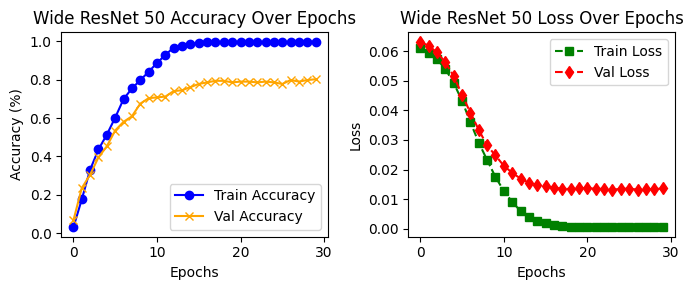

In [ ]:
# Plot training and validation accuracy and loss of Wide ResNet
plot_metrics(metrics_wideresnet, title_prefix="Wide ResNet 50")

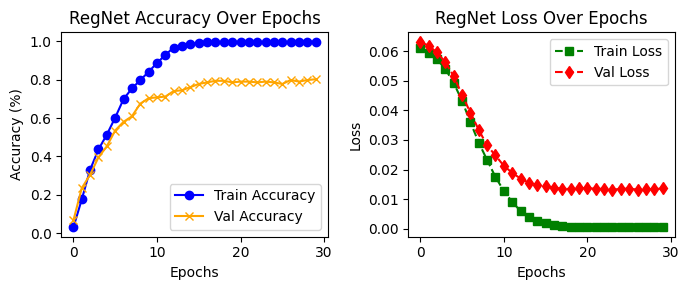

In [ ]:
# Plot training and validation accuracy and loss of RegNet
plot_metrics(metrics_wideresnet, title_prefix="RegNet")

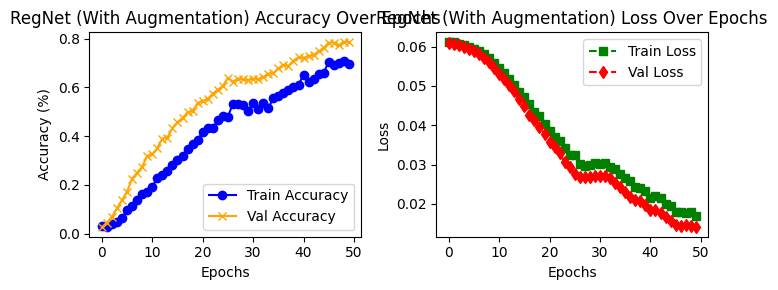

In [ ]:
# Plot training and validation accuracy and loss of RegNet
plot_metrics(metrics_regnet_aug, title_prefix="RegNet (With Augmentation)")

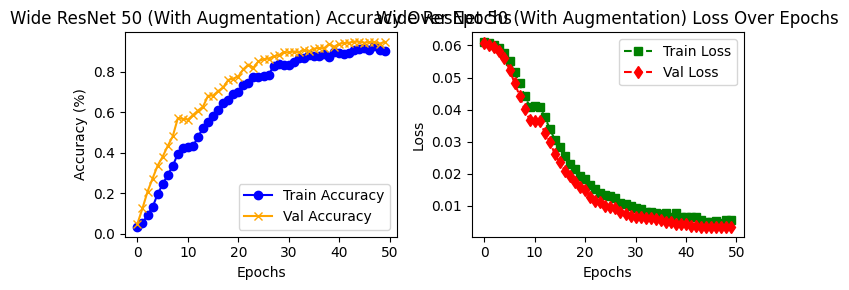

In [ ]:
# Plot training and validation accuracy and loss of RegNet
plot_metrics(metrics_wideresnet_aug, title_prefix="Wide ResNet 50 (With Augmentation)")

### Summary
- From the plots, Wide ResNet 50 eliminates both underfitting and overfitting issues.
- Wide ResNet has validation accuracy of 94% and training accuracy of 90%.
  
- Both models trained without data augmentation have overfitting issues.
- RegNet trained with data augmentation and scheduler have slight underfitting issues.

## 5 Evaluate

### 5.1 Evaluation on Entire Dataset
Model is evaluated on test set from entire dataset.

In [ ]:
# Model Accuracy - With Scheduler
test_metrics_regnet = evaluate_model(model_regnet, test_loader, criterion, device)
test_metrics_wideresnet = evaluate_model(model_wideresnet, test_loader, criterion, device)

# Model Accuracy - With Augmentation
test_metrics_regnet_aug = evaluate_model(model_regnet_aug, test_loader_aug, criterion, device)
test_metrics_wideresnet_aug = evaluate_model(model_wideresnet_aug, test_loader_aug, criterion, device)

In [ ]:
eval_acc_data = {
    "Model": ["RegNet", "WideResNet", "RegNet with Augmentation", "WideResNet with Augmentation"],
    "Test Accuracy": [
        test_metrics_regnet['total_acc'].cpu(),
        test_metrics_wideresnet['total_acc'].cpu(),
        test_metrics_regnet_aug['total_acc'].cpu(),
        test_metrics_wideresnet_aug['total_acc'].cpu()
    ]
}
accuracy_table = pd.DataFrame(eval_acc_data)

print(accuracy_table)

                          Model   Test Accuracy
0                        RegNet  tensor(0.7538)
1                    WideResNet  tensor(0.7840)
2      RegNet with Augmentation  tensor(0.7818)
3  WideResNet with Augmentation  tensor(0.9374)


### 5.2 Evaluation on dataset Collected by me
The data collected by me i.e. images from countries 'United Kingdom' and 'Australia' are filtered from the test set and used for evaluation.

In [ ]:
test_data_prajwal = test_data[(test_data['country'] == 'Australia') | (test_data['country'] == 'United Kingdom')]

# without augmentation
test_dataset_prajwal = COINS(test_data_prajwal)
test_loader_prajwal = DataLoader(test_dataset_prajwal, batch_size=64, shuffle=False)

# with augmentation
test_dataset_aug_prajwal = COINS(test_data_prajwal, transform=transform['val'])
test_loader_aug_prajwal = DataLoader(test_dataset_aug_prajwal, batch_size=64, shuffle=False)

In [ ]:
# Model Accuracy - With Scheduler
test_metrics_regnet_prajwal = evaluate_model(model_regnet, test_loader_prajwal, criterion, device)
test_metrics_wideresnet_prajwal = evaluate_model(model_wideresnet, test_loader_prajwal, criterion, device)

# Model Accuracy - With Augmentation
test_metrics_regnet_aug_prajwal = evaluate_model(model_regnet_aug, test_loader_aug_prajwal, criterion, device)
test_metrics_wideresnet_aug_prajwal = evaluate_model(model_wideresnet_aug, test_loader_aug_prajwal, criterion, device)

In [ ]:
eval_acc_data_prajwal = {
    "Model": ["RegNet", "WideResNet", "RegNet with Augmentation", "WideResNet with Augmentation"],
    "Test Accuracy": [
        test_metrics_regnet_prajwal['total_acc'].cpu(),
        test_metrics_wideresnet_prajwal['total_acc'].cpu(),
        test_metrics_regnet_aug_prajwal['total_acc'].cpu(),
        test_metrics_wideresnet_aug_prajwal['total_acc'].cpu()
    ]
}
accuracy_table_prajwal = pd.DataFrame(eval_acc_data_prajwal)

print(accuracy_table_prajwal)

                          Model   Test Accuracy
0                        RegNet  tensor(0.7615)
1                    WideResNet  tensor(0.7890)
2      RegNet with Augmentation  tensor(0.7018)
3  WideResNet with Augmentation  tensor(0.7615)


### Summary:
- The test accuracies of Wide ResNet (with augmentation) is 93% whereas all other models have accuracies ranging from 75% to 78%.
- The test accuracy of Wide ResNet (with augmentation) dropped to 76% when evaluated on data collected by me while other models performed quite similar even when the data changed.


### 5.3 Visualize Misclassified Images

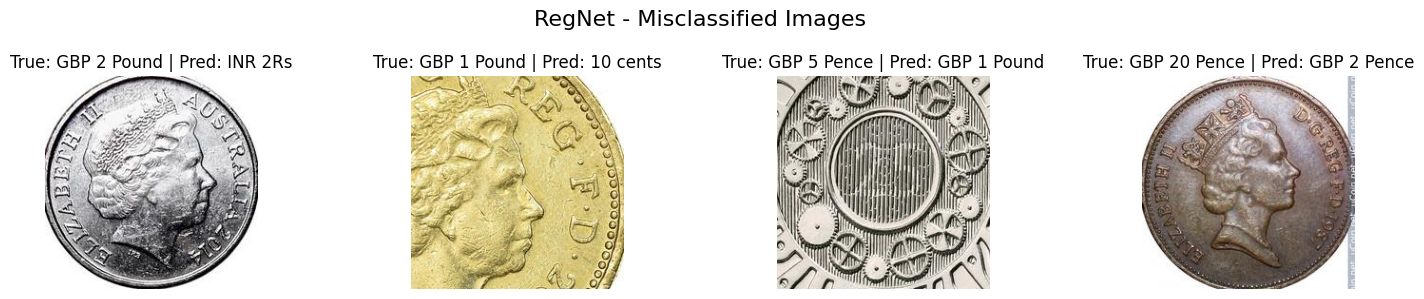

In [ ]:
visualize_misclassified_images(test_metrics_regnet_prajwal, num_images=4, title="RegNet - Misclassified Images")

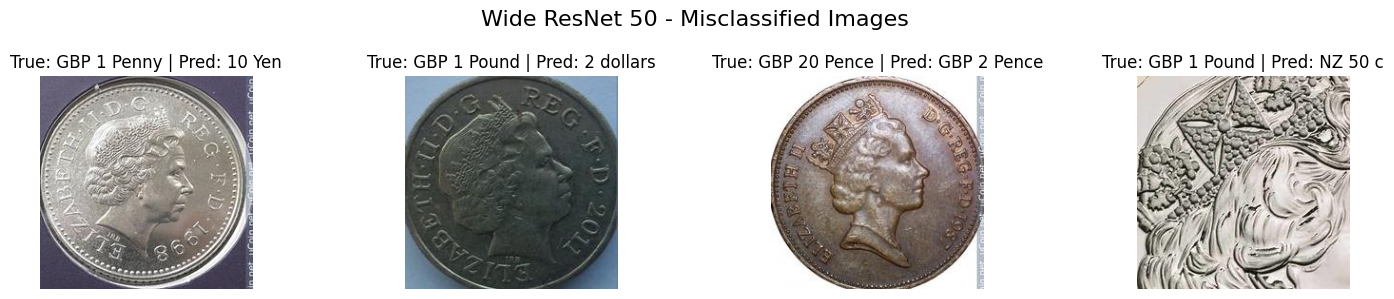

In [ ]:
visualize_misclassified_images(test_metrics_wideresnet_prajwal, num_images=4, title="Wide ResNet 50 - Misclassified Images")

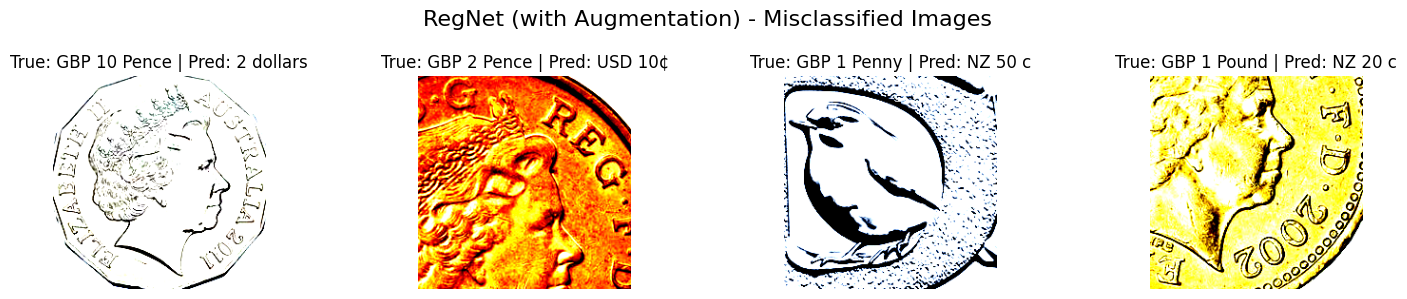

In [ ]:
visualize_misclassified_images(test_metrics_regnet_aug_prajwal, num_images=4, title="RegNet (with Augmentation) - Misclassified Images")

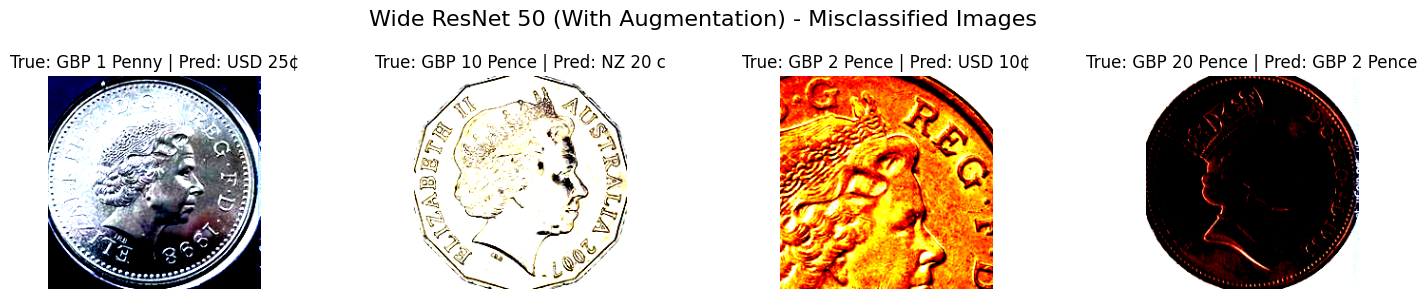

In [ ]:
visualize_misclassified_images(test_metrics_wideresnet_aug_prajwal, num_images=4, title="Wide ResNet 50 (With Augmentation) - Misclassified Images")

### Summary
- Majority of misclassified images are of GBP, where model classifies one GBP coin to other GBP denominations.
- It can be due to similarites in heads side of the coins of GBP coins.
- Moreover, New Zealand coins have similar heads too, which can be the main reason of it in misclassification.

## Conclusion
- The Wide ResNet 50 performed better than RegNet in fine grained vision classification tasks.
- The RegNet might be able to perform with better accuracy with more rigourous finetuning on scheduler and data augmentation.
- OneCycleLR is used for scheduler and only classifer and last layer (block) are finetuned.
- Due to similarities in heads side of the coins from United Kingdom, New Zealand and Australia, it might be difficult to make model generalize on images of heads side of the coin.
- More experiments on data augmentation is required to finetune the model since implementation of data augmentation provided better result.


## New Model

In [159]:
# set the dataset to use only data from Phase 3
df = df_cam

# label encoder
class_names = df['label'].unique()
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Change the image_path to local contents directory
df['image_path'] = df.apply(lambda row: os.path.join(row['URL'], row['image name'].strip()), axis=1)
df['image_path'] = df['image_path'].str.replace('drive/My Drive/CoinImages/', '', regex=False)

In [160]:
# Split the data into training and validation sets
# 60% training, 10 % validation and 30% testing data
train_data_cam, test_val_cam = train_test_split(df, test_size=0.4, stratify=df['encoded_label'])
test_data_cam, val_data_cam = train_test_split(test_val_cam, test_size=0.25, stratify=test_val_cam['encoded_label'])

In [161]:
train_dataset_cam = COINS(train_data_cam, transform=transform['train'])
test_dataset_cam = COINS(test_data_cam, transform=transform['val'])
val_dataset_cam = COINS(val_data_cam, transform=transform['val'])

# Create data loaders
train_loader_cam = DataLoader(train_dataset_cam, batch_size=64, shuffle=True)
test_loader_cam = DataLoader(train_dataset_cam, batch_size=64, shuffle=False)
val_loader_cam = DataLoader(train_dataset_cam, batch_size=64, shuffle=False)

In [162]:
# Create model config
model_config_cam = WideResNetConfig(
    class_names=class_names,
    device=device,
    checkpoint_path='model_wideresnet_aug_model_weights_2025-05-09_09-47.pth'  # or "path/to/your_valid_checkpoint.pth"
)

# Get model
model_wideresnet_cam = model_config_cam.get_model()

Loading checkpoint from model_wideresnet_aug_model_weights_2025-05-09_09-47.pth, excluding final FC layer...


In [163]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_wideresnet_cam.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 20

# define scheduler
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader_aug),
    epochs=num_epochs,
    pct_start=0.3,  # warmup percent of cycle
    anneal_strategy='cos',  # or 'linear'
    div_factor=25.0,        # initial LR = max_lr / div_factor
    final_div_factor=1e4    # final LR = initial LR / final_div_factor
)

In [164]:
model_wideresnet_cam, metrics_wideresnet_cam = train_model(
    model=model_wideresnet_cam,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader_cam,
    val_loader=val_loader_cam,
    scheduler=scheduler,
    num_epochs=num_epochs
)

--------------------
Epoch 0 / 19
train Loss: 0.0302 Acc: 0.2857
val Loss: 0.0232 Acc: 0.4945
--------------------
Epoch 1 / 19
train Loss: 0.0273 Acc: 0.3626
val Loss: 0.0204 Acc: 0.6044
--------------------
Epoch 2 / 19
train Loss: 0.0235 Acc: 0.4835
val Loss: 0.0186 Acc: 0.7033
--------------------
Epoch 3 / 19
train Loss: 0.0229 Acc: 0.4615
val Loss: 0.0167 Acc: 0.7473
--------------------
Epoch 4 / 19
train Loss: 0.0173 Acc: 0.6593
val Loss: 0.0152 Acc: 0.8462
--------------------
Epoch 5 / 19
train Loss: 0.0183 Acc: 0.5495
val Loss: 0.0148 Acc: 0.8462
--------------------
Epoch 6 / 19
train Loss: 0.0184 Acc: 0.6813
val Loss: 0.0143 Acc: 0.8901
--------------------
Epoch 7 / 19
train Loss: 0.0177 Acc: 0.6484
val Loss: 0.0123 Acc: 0.9011
--------------------
Epoch 8 / 19
train Loss: 0.0161 Acc: 0.6923
val Loss: 0.0109 Acc: 0.9011
--------------------
Epoch 9 / 19
train Loss: 0.0150 Acc: 0.6923
val Loss: 0.0114 Acc: 0.9121
--------------------
Epoch 10 / 19
train Loss: 0.0147 Acc: 0

In [ ]:
# model_wideresnet_cam, metrics_wideresnet_cam = train_model(
#     model=model_wideresnet_cam,
#     criterion=criterion,
#     optimizer=optimizer,
#     train_loader=train_loader_cam,
#     val_loader=val_loader_cam,
#     scheduler=scheduler,
#     num_epochs=num_epochs
# )

--------------------
Epoch 0 / 14
train Loss: 0.0315 Acc: 0.2418
val Loss: 0.0255 Acc: 0.2747
--------------------
Epoch 1 / 14
train Loss: 0.0270 Acc: 0.3187
val Loss: 0.0216 Acc: 0.5275
--------------------
Epoch 2 / 14
train Loss: 0.0205 Acc: 0.5055
val Loss: 0.0152 Acc: 0.7802
--------------------
Epoch 3 / 14
train Loss: 0.0166 Acc: 0.6484
val Loss: 0.0106 Acc: 0.8352
--------------------
Epoch 4 / 14
train Loss: 0.0107 Acc: 0.7912
val Loss: 0.0064 Acc: 0.9121
--------------------
Epoch 5 / 14
train Loss: 0.0081 Acc: 0.9121
val Loss: 0.0056 Acc: 0.8901
--------------------
Epoch 6 / 14
train Loss: 0.0078 Acc: 0.8901
val Loss: 0.0057 Acc: 0.9121
--------------------
Epoch 7 / 14
train Loss: 0.0080 Acc: 0.8791
val Loss: 0.0054 Acc: 0.9451
--------------------
Epoch 8 / 14
train Loss: 0.0037 Acc: 0.9231
val Loss: 0.0055 Acc: 0.9451
--------------------
Epoch 9 / 14
train Loss: 0.0061 Acc: 0.9011
val Loss: 0.0023 Acc: 0.9670
--------------------
Epoch 10 / 14
train Loss: 0.0040 Acc: 0

In [ ]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
file_name = f"model_wideresnet_cam_weights_{current_time}.pth"
torch.save(model_wideresnet_cam.state_dict(), file_name)

In [165]:
test_metrics_cam_img = evaluate_model(model_wideresnet_cam, test_loader_cam, criterion, device)

In [166]:
test_metrics_cam_img['total_acc'].cpu()

tensor(0.8462)

In [125]:
# Define model
model_wideresnet_cam = get_finetuned_wideresnet_model(class_names, device)

# Construct filename (replace with actual if you know it)
file_name = f"model_wideresnet_cam_weights_2025-05-29_09-30.pth"

# Load state dict
model_wideresnet_cam.load_state_dict(torch.load(file_name, map_location=device))

<All keys matched successfully>

In [126]:
test_metrics_cam_img = evaluate_model(model_wideresnet_cam, test_loader_cam, criterion, device)

In [127]:
test_metrics_cam_img['total_acc'].cpu()

tensor(0.9451)

## Evaluate on model from Phase 2

In [216]:
# set the dataset to use data from both Phase 2 and Phase 3 for only choosen 3 Classes
df = df_cam

# label encoder
class_names_phase2 = df_coins['label'].unique()
class_names = class_names_phase2
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Change the image_path to local contents directory
df['image_path'] = df.apply(lambda row: os.path.join(row['URL'], row['image name'].strip()), axis=1)
df['image_path'] = df['image_path'].str.replace('drive/My Drive/CoinImages/', '', regex=False)

In [217]:
# Split the data into training and validation sets
# 60% training, 10 % validation and 30% testing data
train_data_cam_p2, test_val_cam_p2 = train_test_split(df, test_size=0.4, stratify=df['encoded_label'], random_state=5)
test_data_cam_p2, val_data_cam_p2 = train_test_split(test_val_cam_p2, test_size=0.25, stratify=test_val_cam_p2['encoded_label'], random_state=5)

In [218]:
train_dataset_cam_p2 = COINS(train_data_cam_p2, transform=transform['train'])
test_dataset_cam_p2 = COINS(test_data_cam_p2, transform=transform['val'])
val_dataset_cam_p2 = COINS(val_data_cam_p2, transform=transform['val'])

# Create data loaders
train_loader_cam_p2 = DataLoader(train_dataset_cam_p2, batch_size=64, shuffle=True)
test_loader_cam_p2 = DataLoader(train_dataset_cam_p2, batch_size=64, shuffle=False)
val_loader_cam_p2 = DataLoader(train_dataset_cam_p2, batch_size=64, shuffle=False)

In [219]:

# Define model
model_wideresnet_phase2 = get_finetuned_wideresnet_model(class_names_phase2, device)

# Construct filename (replace with actual if you know it)
file_name = f"model_wideresnet_aug_model_weights_2025-05-09_09-47.pth"

# Load state dict
model_wideresnet_phase2.load_state_dict(torch.load(file_name, map_location=device))

<All keys matched successfully>

In [46]:
test_metrics_phase2 = evaluate_model(model_wideresnet_phase2, test_loader_cam_p2, criterion, device)
test_metrics_phase2['total_acc'].cpu()

tensor(0.0659)

## Combined Data

In [259]:
# set the dataset to use data from both Phase 2 and Phase 3 for only choosen 3 Classes
df = filtered_df

# label encoder
class_names = df['label'].unique()
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Change the image_path to local contents directory
df['image_path'] = df.apply(lambda row: os.path.join(row['URL'], row['image name'].strip()), axis=1)
df['image_path'] = df['image_path'].str.replace('drive/My Drive/CoinImages/', '', regex=False)

In [260]:
# Split the data into training and validation sets
# 60% training, 10 % validation and 30% testing data
train_data_combined, test_val_combined = train_test_split(df, test_size=0.4, stratify=df['encoded_label'])
test_data_combined, val_data_combined = train_test_split(test_val_combined, test_size=0.25, stratify=test_val_combined['encoded_label'])

In [261]:
train_dataset_combined = COINS(train_data_combined, transform=transform['train'])
test_dataset_combined = COINS(test_data_combined, transform=transform['val'])
val_dataset_combined = COINS(val_data_combined, transform=transform['val'])

# Create data loaders
train_loader_combined = DataLoader(train_dataset_combined, batch_size=64, shuffle=True)
test_loader_combined = DataLoader(train_dataset_combined, batch_size=64, shuffle=False)
val_loader_combined = DataLoader(train_dataset_combined, batch_size=64, shuffle=False)

In [262]:
# Create model config
model_config_combined = WideResNetConfig(
    class_names=class_names,
    device=device,
    checkpoint_path='model_wideresnet_aug_model_weights_2025-05-09_09-47.pth'  # or "path/to/your_valid_checkpoint.pth"
)

# Get model
model_wideresnet_combined = model_config_combined.get_model()

Loading checkpoint from model_wideresnet_aug_model_weights_2025-05-09_09-47.pth, excluding final FC layer...


In [263]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_wideresnet_combined.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 15

# define scheduler
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader_combined),
    epochs=num_epochs,
    pct_start=0.3,  # warmup percent of cycle
    anneal_strategy='cos',  # or 'linear'
    div_factor=25.0,        # initial LR = max_lr / div_factor
    final_div_factor=1e4    # final LR = initial LR / final_div_factor
)

In [264]:
model_wideresnet_combined, metrics_wideresnet_combined = train_model(
    model=model_wideresnet_combined,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader_combined,
    val_loader=val_loader_combined,
    scheduler=scheduler,
    num_epochs=num_epochs
)

--------------------
Epoch 0 / 14
train Loss: 0.0268 Acc: 0.3407
val Loss: 0.0210 Acc: 0.5934
--------------------
Epoch 1 / 14
train Loss: 0.0229 Acc: 0.4505
val Loss: 0.0146 Acc: 0.7033
--------------------
Epoch 2 / 14
train Loss: 0.0178 Acc: 0.6264
val Loss: 0.0083 Acc: 0.9231
--------------------
Epoch 3 / 14
train Loss: 0.0098 Acc: 0.8352
val Loss: 0.0041 Acc: 0.9560
--------------------
Epoch 4 / 14
train Loss: 0.0055 Acc: 0.9011
val Loss: 0.0019 Acc: 0.9890
--------------------
Epoch 5 / 14
train Loss: 0.0021 Acc: 0.9890
val Loss: 0.0003 Acc: 1.0000
--------------------
Epoch 6 / 14
train Loss: 0.0024 Acc: 0.9341
val Loss: 0.0003 Acc: 1.0000
--------------------
Epoch 7 / 14
train Loss: 0.0019 Acc: 0.9560
val Loss: 0.0002 Acc: 1.0000
--------------------
Epoch 8 / 14
train Loss: 0.0016 Acc: 0.9670
val Loss: 0.0014 Acc: 0.9890
--------------------
Epoch 9 / 14
train Loss: 0.0020 Acc: 0.9670
val Loss: 0.0015 Acc: 0.9890
--------------------
Epoch 10 / 14
train Loss: 0.0017 Acc: 0

In [105]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
file_name = f"model_wideresnet_cam_combined_weights_{current_time}.pth"
torch.save(model_wideresnet_combined.state_dict(), file_name)

## Evaluate

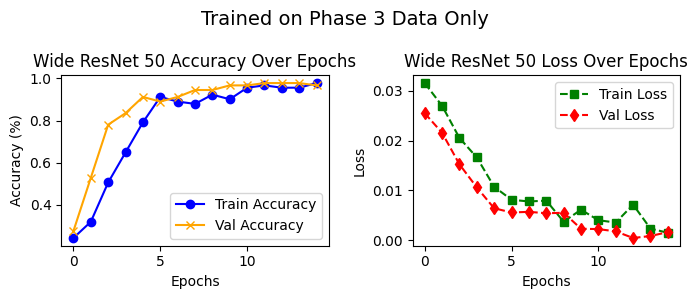

In [ ]:
# Plot training and validation accuracy and loss of Wide ResNet
plot_metrics_updated(metrics_wideresnet_cam, title_prefix="Wide ResNet 50", sup_title="Trained on Phase 3 Data Only")

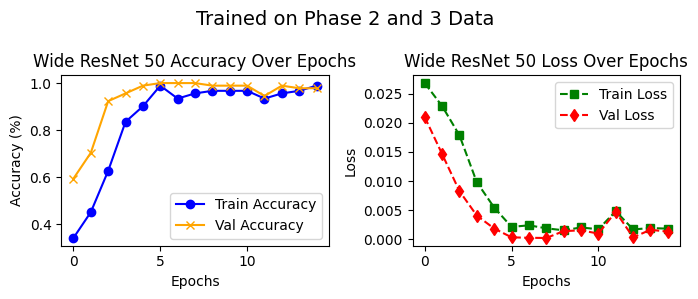

In [265]:
# Plot training and validation accuracy and loss of Wide ResNet
plot_metrics_updated(metrics_wideresnet_combined, title_prefix="Wide ResNet 50", sup_title="Trained on Phase 2 and 3 Data")

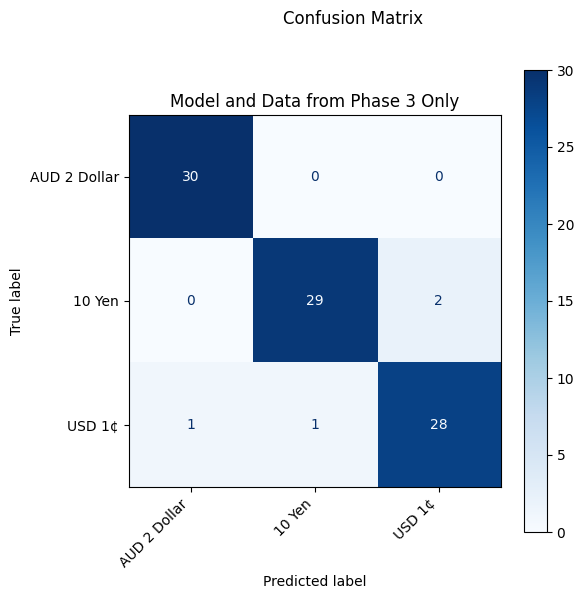

In [196]:
class_names = df_cam['label'].unique()
# plot_confusion_matrix(model_wideresnet_cam, test_loader_cam, device, class_names, title='Model and Data from Phase 3 Only')
test_metrics_cam = plot_confusion_matrix(model_wideresnet_cam, test_loader_cam, device, class_names, title='Model and Data from Phase 3 Only')

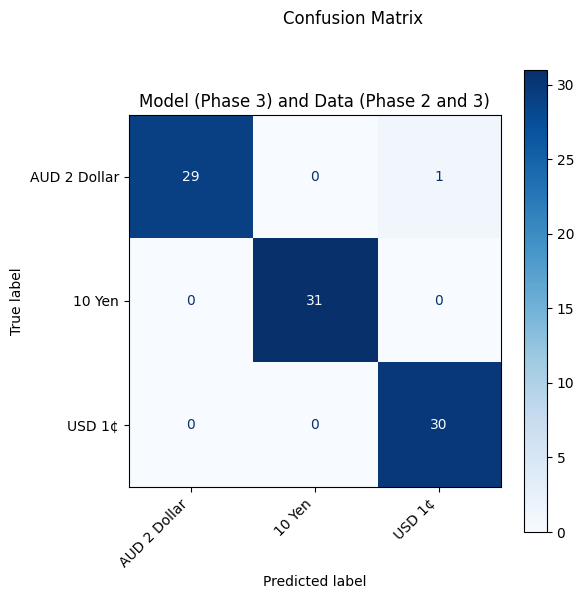

In [268]:
class_names = filtered_df['label'].unique()
# plot_confusion_matrix(model_wideresnet_combined, test_loader_combined, device, class_names, title='Model (Phase 3) and Data (Phase 2 and 3)')
test_metrics_combined = plot_confusion_matrix(model_wideresnet_combined, test_loader_combined, device, class_names, title='Model (Phase 3) and Data (Phase 2 and 3)')


In [203]:
class_names = class_names_phase2
test_metrics_phase2 = test_metrics(model_wideresnet_phase2, test_loader_cam_p2, device)

In [273]:
data = [
    ('WideResNet - Phase 2', *test_metrics_phase2),
    ('WideResNet - Phase 3 Images ', *test_metrics_cam),
    ('WideResNet - Phase 2 and 3 Images ', *test_metrics_combined),
]

# Create DataFrame
df = pd.DataFrame(data, columns=['Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

print(df)

                                 Name  Accuracy  Precision    Recall  F1 Score
0                WideResNet - Phase 2  0.054945   0.206044  0.054945  0.086755
1        WideResNet - Phase 3 Images   0.989011   0.989365  0.989011  0.989008
2  WideResNet - Phase 2 and 3 Images   0.989011   0.989365  0.989011  0.989008


In [279]:
print(len(class_names_test))

48


In [290]:
import numpy as np

def get_unique_labels(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())
    return np.unique(all_labels)

In [291]:
unique_labels = get_unique_labels(test_loader_aug)
filtered_class_names = [class_names_test[i] for i in unique_labels]

In [303]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions_and_labels_test(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)


def plot_confusion_matrix_test(model, dataloader, device, class_names, title, use_seaborn=False, normalize=True):
    preds, labels = get_predictions_and_labels_test(model, dataloader, device)
    cm = confusion_matrix(labels, preds, normalize='true')

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)

    if use_seaborn:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.title(title + (" (Normalized)" if normalize else ""))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    else:
        from sklearn.metrics import ConfusionMatrixDisplay
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
        plt.xticks(rotation=45, ha='right')
        plt.title(title)
        plt.suptitle('Confusion Matrix')
        plt.show()

    return accuracy, precision, recall, f1


In [304]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_heatmap(labels, preds, class_names, title, normalize=True):
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(16, 14))  # Big figure for many classes
    sns.set(font_scale=0.8)       # Smaller font size for tick labels

    ax = sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                     xticklabels=class_names, yticklabels=class_names,
                     cbar_kws={'label': 'Proportion' if normalize else 'Count'})

    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


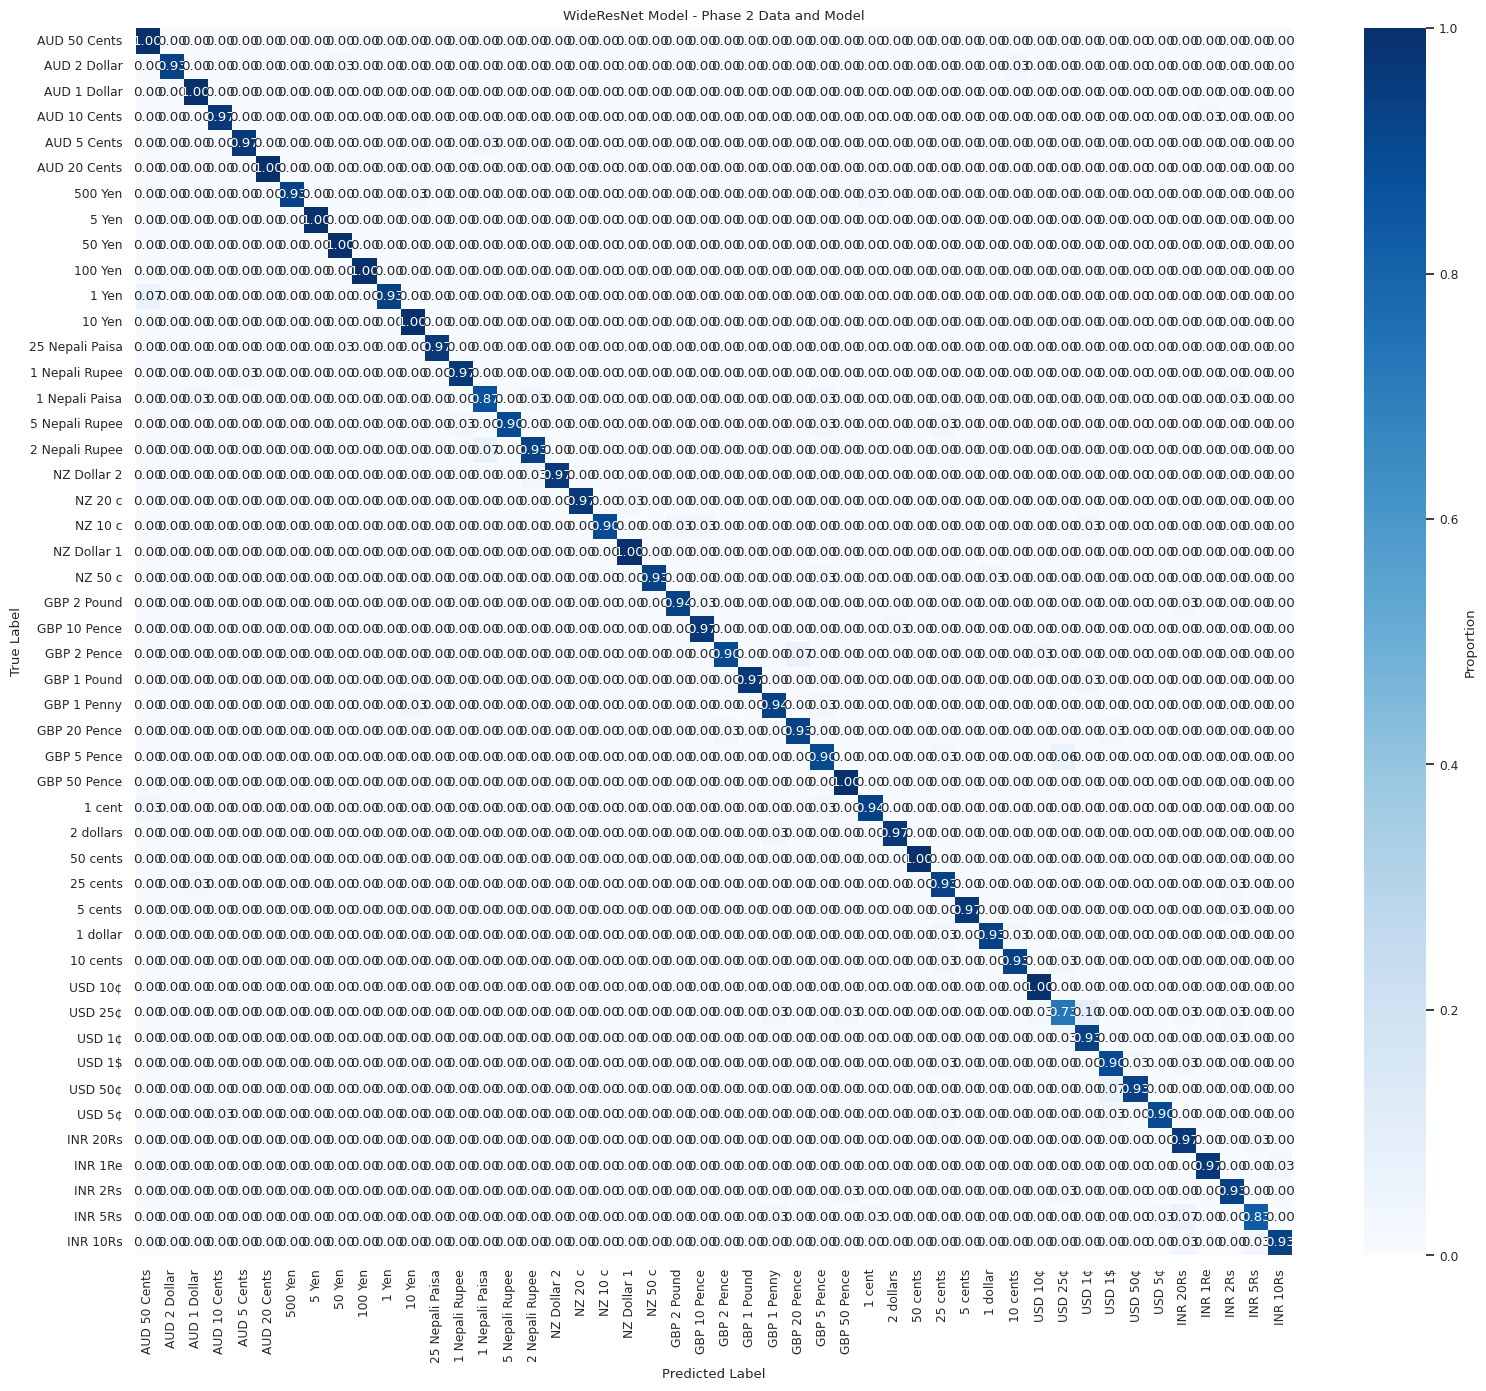

In [307]:
# Get predictions and labels (reuse your function or inline here)
preds, labels = get_predictions_and_labels(model_wideresnet_test, test_loader_aug, device)

plot_confusion_heatmap(labels, preds, class_names, title='WideResNet Model - Phase 2 Data and Model')


In [300]:
class_names_test = df_coins['label'].unique()
# Create model config
model_config_test = WideResNetConfig(
    class_names=class_names_test,
    device=device,
    checkpoint_path='model_wideresnet_aug_model_weights_2025-05-09_09-47.pth'  # or "path/to/your_valid_checkpoint.pth"
)

# Get model
model_wideresnet_test = model_config_test.get_model()

Loading checkpoint from model_wideresnet_aug_model_weights_2025-05-09_09-47.pth, excluding final FC layer...


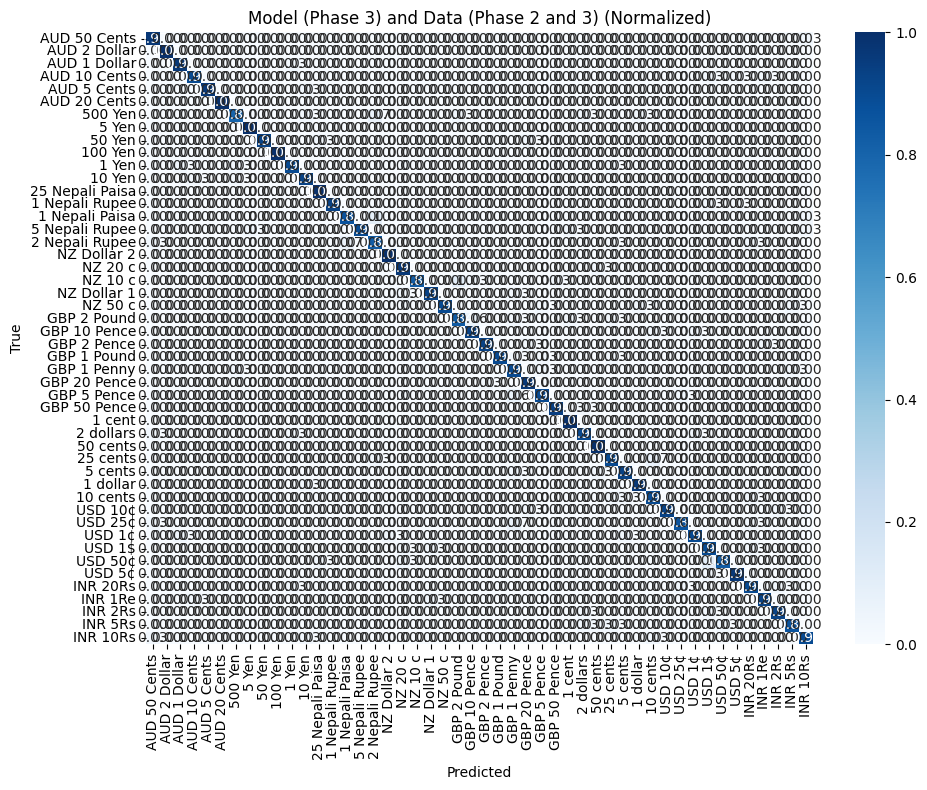

In [301]:
# plot_confusion_matrix(model_wideresnet_combined, test_loader_combined, device, class_names, title='Model (Phase 3) and Data (Phase 2 and 3)')
test_metrics_combined = plot_confusion_matrix_test(model_wideresnet_test, test_loader_aug, device, class_names, title='Model (Phase 3) and Data (Phase 2 and 3)', use_seaborn=True)


In [295]:
test_metrics_combined

(0.94287680660702, 0.946182452185863, 0.94287680660702, 0.9432810431078601)

## References

- https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://www.learnpytorch.io/06_pytorch_transfer_learning/
- https://docs.pytorch.org/vision/main/models.html